<div class="alert alert-block alert-danger">
    <b>Warning:</b> As of 2021/11/11, this notebook is incomplete and still a work-in-progress
</div>

<div class="alert alert-block alert-info">
    <b>Tip:</b> Use <b>%matplotlib widget</b> or <b>%matplotlib notebook</b> for interactive plots when notebook is running locally on your computer
</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CARDIAL-nyu/cmr-playground/blob/main/golden_angle_sample/Sample%20XD-GRASP%20Type%20Radial%20-%20Multi%20Coil.ipynb)

In [1]:
import sys
# interactive matplotlib doesn't work on google colab, so fall back to inline
if 'miniconda' not in sys.executable:
    %matplotlib inline
    !{sys.executable} -m pip install --force https://github.com/chengs/tqdm/archive/colab.zip
    !{sys.executable} -m pip install sigpy h5py
    ! git clone https://github.com/CARDIAL-nyu/cmr-playground
    %cd cmr-playground/golden_angle_sample
else:
    %matplotlib notebook

# Mult-Coil Example
In the previous `Sample XD-GRASP Type Radial - Single Coil` notebook, we assumed that we were imaging with a **single coil**, yielding a single matrix of k-space data.  Here, we use previously calculated coil sensitivities (via the ESPIRiT algorithm) in order to simulate an imaging process that produces multi-coil k-space data.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io
import seaborn as sns
import sigpy
import sigpy.plot
import sigpy.mri
import h5py

plt.style.use('fivethirtyeight')
five_thirty_eight = [
"#30a2da",
"#fc4f30",
"#e5ae38",
"#6d904f",
"#8b8b8b",
]
sns.set_palette(five_thirty_eight, color_codes=True)
sns.set_color_codes()

mpl.rcParams['axes.grid'] = False

# Load in a sample OCMR reconstruction

In [3]:
reconstructed_filename = 'output_slice1_us_0156_pt_1_5T_reshapeF_slice4.mat'
slice_mat = scipy.io.loadmat(reconstructed_filename)

In [4]:
# What's inside this container...
slice_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'xHat', 'pOut', 'xHat_abs_norm'])

### Dimensions
 - `n_ro`: number of samples in the readout direction
 - `n_pe`: number of phase-encoding lines
 - `n_frames`: number of frames in this cine

In [5]:
n_ro, n_pe, n_frames = slice_mat['xHat_abs_norm'].shape
n_ro, n_pe, n_frames

(352, 134, 30)

### Create a square frame
 - for ease, let's deal with square images by zero-filling the borders

In [6]:
selected_frame = 0 # let's work with the 1st frame of the cine
square_cine = np.zeros((n_ro, n_ro))
square_cine[:,(n_ro-n_pe)//2:-(n_ro-n_pe)//2] = slice_mat['xHat_abs_norm'][...,selected_frame]
square_cine.shape

(352, 352)

### Visualize the frame we're dealing with

<IPython.core.display.Javascript object>


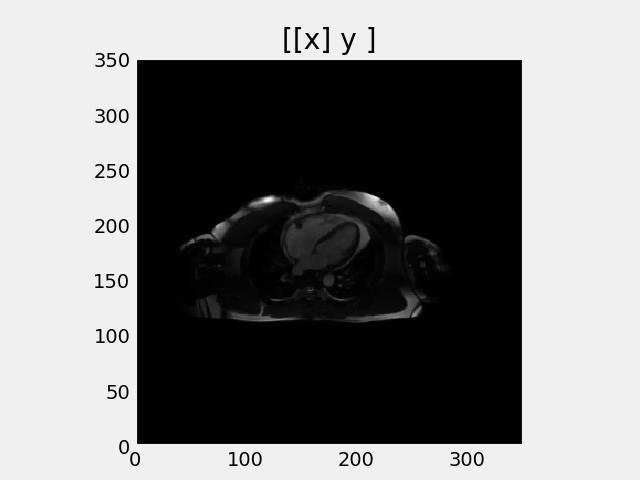

In [7]:
sigpy.plot.ImagePlot(square_cine, x=0, y=1)

# Read in the coil sensitivity maps

In [8]:
ocmr_id = reconstructed_filename.split('_reshape')[0].replace('output_slice1_','')
a_coil_sense_map = scipy.io.loadmat(f'espirit_{ocmr_id}.mat')['espirit_map']

n_coils_sense, n_ro_sense, n_pe_sense = a_coil_sense_map.shape

square_sense_map = np.zeros((n_coils_sense, n_ro_sense, n_ro_sense), dtype=complex)
square_sense_map[:, :,(n_ro_sense-n_pe_sense)//2:-(n_ro_sense-n_pe_sense)//2] = a_coil_sense_map

n_coils_sense, n_ro_sense, n_pe_sense, square_sense_map.shape

(20, 352, 126, (20, 352, 352))

<IPython.core.display.Javascript object>


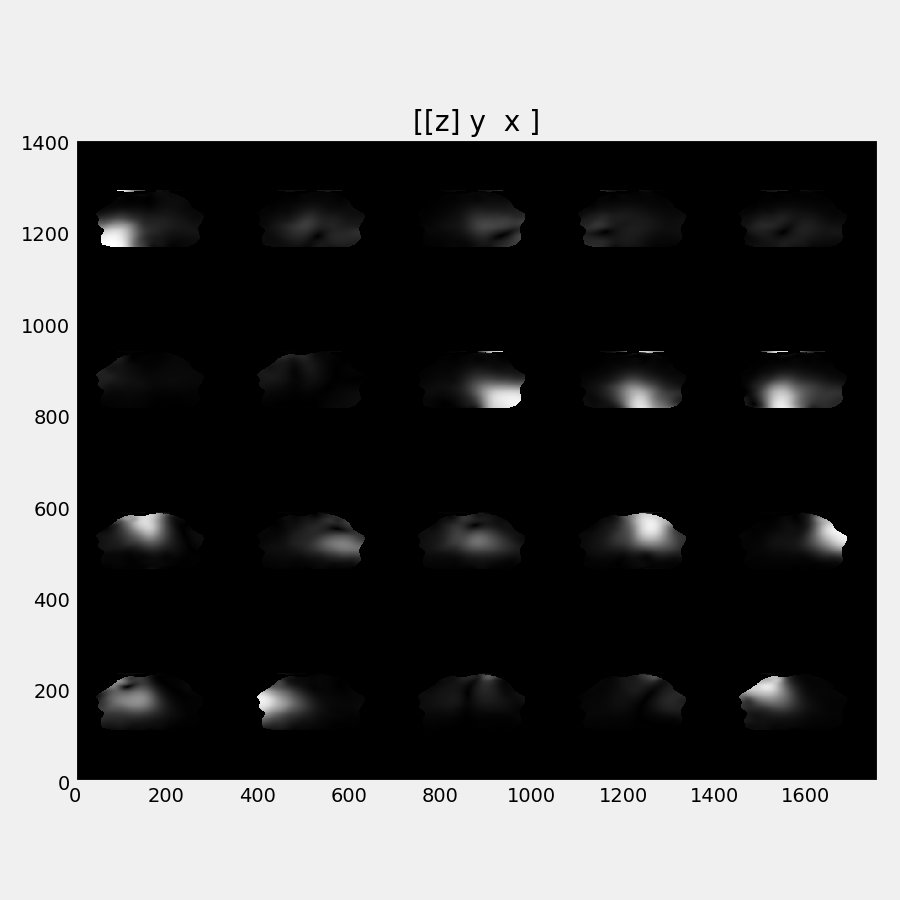

In [9]:
i_coil_maps = sigpy.plot.ImagePlot(square_sense_map.transpose((0,2,1)), z=0) # transpose so the body is horizontal

i_coil_maps.fig.set_figwidth(9)
i_coil_maps.fig.set_figheight(9)

i_coil_maps.fig.tight_layout()

# Helper functions
 - `return_ga_traj` returns the tiny golden angle kspace trajectory

In [10]:
def return_ga_traj(nX, ntviews, tiny_num=7):
    """Returns tiny golden angle trajectory and density compensation

    Parameters
    ----------
    nX : int
        number of readout points
    ntviews : int
        number of radial spokes/turns
    tiny_num : int
        type of golden angle, e.g. 7 for 7th tiny golden angle

    Returns
    -------
    traj : ndarray
        trajectory with shape (nX, ntviews)
    densitycomp : ndarray

    Reference
    ---------
    https://doi.org/10.1002/mrm.25831

    """
    golden_ratio = (np.sqrt(5.0) + 1.0) / 2.0
    golden_angle = np.pi / (golden_ratio + tiny_num - 1)

    radian = np.mod(np.arange(0, ntviews) * golden_angle, 2. * np.pi)
    rho = np.arange(-np.floor(nX / 2), np.floor(nX / 2)) + 0.5

    _sin = np.sin(radian)
    _cos = np.cos(radian)

    # Complex trajectory
    traj = np.stack(((rho[..., np.newaxis] * _sin[np.newaxis, ...]),
                     (rho[..., np.newaxis] * _cos[np.newaxis, ...])), axis=2)
    
    # Density Compensation
    densitycomp = np.sqrt(np.power(traj[...,0], 2) + np.power(traj[...,1], 2))
    densitycomp /= densitycomp.max()
    
    # Reshape into (n_spokes, n_readout, 2)
    traj = traj.transpose((1,0,2))
    
    # Reshape into (n_spokes, n_readout)
    densitycomp = densitycomp.transpose((1,0))
    
    return traj, densitycomp

In [27]:
320*np.pi/2

502.6548245743669

### Create a radial trajectory based off of the nyquist rate
 - nyquist criteria for radial trajectories is $\frac{\textrm{N}\pi}{2}$, where $\textrm{N}$ is the number of lines required for fully-sampled data in cartesian sampling.  In this case, it is equal to `n_ro`.

# Quick Aside

### Frame image from sequentially acquired radial spokes

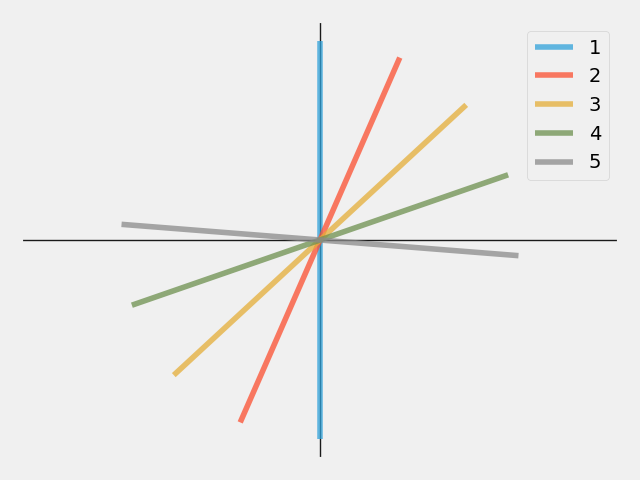

 - if one single frame of the cine was acquired with sequentially incremented radial spokes in k-space, the 1st 5 radial spokes for that frame might something look like this figure-- the 1st acquired spoke is blue, ..., the 5th acquired spoke is the gray.
   - for a fully sampled frame that is 320x320, we might have $\frac{\textrm{320}\pi}{2} \approx 502$ total number of spokes, but here only the first 5 is shown for clarity of how each sucessive spoke follows the previous spoke by a constant increment.
 - **note:** each spoke follows the next by the same angular increment

### Reality for CMR: image from stitched together spokes
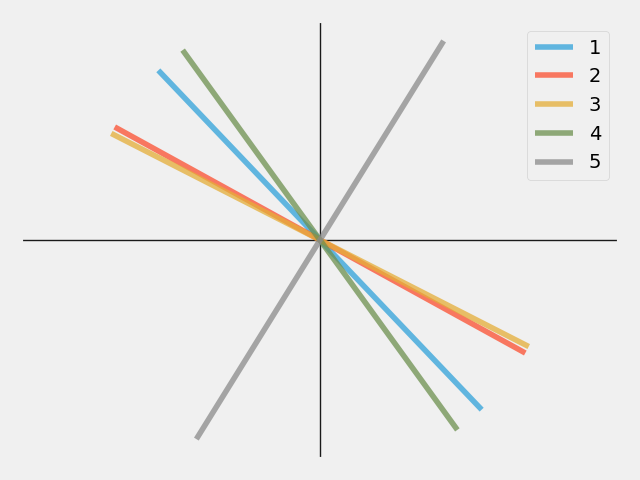

 - in reality, we typically cannot acquire all k-space data for a particular cardiac state all at once to fully form an image frame.  instead, we continuously collect k-space data across a number of heart beats, (say 5 heart beats)
   - then with some type of signal that represents the dynamically changing cardiac state that occurs during each filling and ejection cycle (e.g. an EKG signal), we can **sort** the k-space data.
   - **sort** means that we can take the continous stream of radial spokes acquired across the 5 heart beats and group them together according to how far into a cardiac cycle it was when they were acquired.
   - for instance, if we want to reconstruct a frame that represents the heart at the beginning of systole (i.e. a heart that is about to eject), we can look at an EKG recording across the 5 beats, figure out the times around the 5 R-waves of the QRS complexes, then find all the radial spokes that were acquired around those times.
   - then we can stitch those radial spokes together that were acquired at approximately the same cardiac state (beginning of systole), but were not acquired sequentially.
 - this means that our spokes are no longer separated by a constant angular increment, but instead can potentially be clumped up in some quadrants and sparse in another quadrant. an example of the 1st 5 spokes after this sorting process might look something like the figure below.
 - **note:** some spokes are very close together, others are pretty far from the clump.
 - this more irregular pattern of spokes adds a little more complexity to the reconstruction process
 - if we consider that each frame of a cine has different irregular patterns of sampling, this **incoherence** feature can be used to our advantage in compressed sensing type reconstructions, because aliasing artifacts due to undersampling will be more diffuse across the image.
   - then if each frame of a cine has non-identical aliasing artifacts, they can be jointly used to "fill in the gaps" wherein one region of a frame may be contaminated by aliasing, but in other frames, this same region appears essentially alias-free.

## Let's try to simulate this irregular radial sampling pattern
#### Plan 1:
**Step 1.** we will use `return_ga_traj()` to simulate some large number of radial spokes that were acquired sequentially in time, say `55,000` spokes.

**Step 2.** for this first simple demonstration, we will assume that each frame of the cine will contain the same number of radial spokes, e.g. `100` spokes for each frame.  since we have a sequence of `55,000` spokes, we can randomly sample, without replacement, `100` spokes from the `55,000`.  this will result in each frame having `100` radial spokes that may be irregularly spaced.
 - if each frame would require ~`500` spokes to be considered fully-sampled, this would mean that with only `100` spokes per frame, we've done a 5x undersampling.
 
#### Plan 2:
Similar to **Plan 1.** above, but we will relax the requirement that each frame have an identical number of spokes.  Some frames may have more than `100` spokes, others may have less than `100` spokes.  For instance, maybe in some frames corresponding to systole, we are severely undersampled due to quick motions and some frames only have `70` spokes.  Then in frames corresponding to end-diastole when the heart is not as dynamic in motion, we have frames that have many more spokes, say `220` spokes.

## Plan 1:
### Step 1.

In [28]:
# 1. we will use return_ga_traj() to simulate some large number of radial spokes that were 
#    acquired sequentially in time, say 55,000 spokes.
traj, dc = return_ga_traj(nX=n_ro, ntviews=55000)

n_ro, ntviews, traj.shape, dc.shape

(352, 552, (55000, 352, 2), (55000, 352))

### Step 2.

In [29]:
np.random.seed(20211110)

num_spokes_per_frame = 100

- we will now randomly sample 100 spokes for 30 frames of the cine
- below, we will get a list of 30 sets of 100 indices that we can use to pull out those spokes from the trajectory calculated in **Step 1.**

In [31]:
spoke_indices = np.random.choice(traj.shape[0], (n_frames, num_spokes_per_frame), replace=False)
spoke_indices.shape

(30, 100)

 - let's visualize the 1st 5 spokes of each frame of the cine to verify they have irregular sampling patterns

<div class="alert alert-block alert-danger">
    <b>Warning:</b> Incomplete below....
</div>

In [12]:
num_spokes = ntviews

np.random.seed(456)

ind = np.arange(traj.shape[0])
np.random.shuffle(ind)
traj_random = traj[ind[:num_spokes],:,:]

f_sk, ax_sk = plt.subplots(1,1)
ax_sk.scatter(traj_random[...,0], traj_random[...,1], s=1)

ax_sk.axis('equal')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-193.0499711258094, 193.0499711258094, -193.0499911768323, 193.0499911768323)

# Use the SENSE linear operator to produce multi-coil k-space data
 - this essentially produces data from various perspectives corresponding to the location of each coil element.

In [13]:
traj_random.shape

(552, 352, 2)

In [14]:
# Without passing coord to Sense(), this will return multi-coil cartesian kspace data
S = sigpy.mri.linop.Sense(mps=square_sense_map)

# When coordinates are passed to Sense(), it will use an NUFFT internally to give us multi-coil non-cartesian kspace data
S_nc = sigpy.mri.linop.Sense(mps=square_sense_map, coord=traj_random)

S, S_nc

(<[20, 352, 352]x[352, 352]> Sense Linop>,
 <[20, 552, 352]x[352, 352]> Sense Linop>)

In [15]:
# Multi-coil cartesian kspace
ksp_mc = S*square_cine

# Multi-coil non-cartesian kspace
ksp_mc_nc = S_nc*square_cine

ksp_mc.shape, ksp_mc_nc.shape

((20, 352, 352), (20, 552, 352))

In [16]:
# Create the inverse FFT linear operator
IFFT = sigpy.linop.IFFT(shape=S.oshape)
NUFFT = sigpy.linop.NUFFT(ishape=S_nc.oshape, coord=traj_random)
NUFFT_H = sigpy.linop.NUFFTAdjoint(oshape=square_sense_map.shape, coord=traj_random)

In [18]:
# Apply the SENSE and IFFT operators to produce the coil images
coil_images = IFFT*ksp_mc
# arrange in coils, y, x
coil_images = coil_images.transpose((0,2,1))
i_coil_images = sigpy.plot.ImagePlot(coil_images, z=0)

i_coil_images.fig.set_figwidth(9)
i_coil_images.fig.set_figheight(9)

i_coil_images.fig.tight_layout()

# better contrast/brightness found from keyboard shortcuts [, ], {, and }
# if in interactive matplotlib, you can hit the h key to bring up the shortcuts menu
i_coil_images.vmin, i_coil_images.vmax = (-0.013655932664425219, 0.3889218833905934)
i_coil_images.update_image()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
pc = sigpy.mri.kspace_precond(mps=square_sense_map, coord=traj_random, lamda=0.01)
print(pc.shape)

sigpy.plot.ImagePlot(NUFFT_H*(ksp_mc_nc*pc), x=1, y=2)

(20, 552, 352)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
p = sigpy.mri.pipe_menon_dcf(coord=traj_random)
print(p.shape)

sigpy.plot.ImagePlot(NUFFT_H*(ksp_mc_nc*p[np.newaxis,...]), x=1, y=2)

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

(552, 352)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

- Use the golden-angle radial trajectory and the non-uniform FFT operator to transform the image into non-cartesian k-space

In [21]:
NUFFT = sigpy.linop.NUFFT(ishape=square_cine[np.newaxis,...].shape,
                          coord=traj)
# Apply the operator to transform the image into non-cartesian k-space
ksp_radial = NUFFT*square_cine[np.newaxis,...] # add a singleton dimension to the front to confirm with sigpy conventions
ksp_radial.shape

(1, 5520, 352)